# Coordinate Transform

In [1]:
import os
from pathlib import Path

import pandas as pd

cwd = Path(os.getcwd())
log_dir = cwd / "../local/log/1121/asc/经纬度定位"
output_path = log_dir / "raw.csv"

## Data Loading

In [2]:
import re
from typing import Mapping, NamedTuple

KEY_VALUE_PATTERN = re.compile(
    r"(?P<key>\w+): (?P<value>-?\d*(?:\.\d*)?)"
)

# log_number -> (center_x, center_y, heading)
INS_POSITIONS: Mapping[str, tuple[float, float, float]] = {
    "1": (545.96, 121.59, -0.03),
    "2": (548.20, 115.70, 3.14),
    "3": (546.05, 109.74, -0.03),
    "4": (544.34, 103.75, -0.05),
    "5": (544.01, 91.73, -0.06),
    "6": (544.30, 79.80, -0.05),
    "7": (544.28, 67.69, 0.02),
    "8": (562.15, 130.49, 3.10),
    "9": (610.01, 138.30, 3.13),
    "10": (630.20, 130.52, 3.12),
    "11": (653.99, 138.23, 3.11),
    "12": (669.99, 130.54, 3.12),
    "13": (690.01, 138.20, 3.14),
    "14": (705.77, 130.46, -3.10),
    "15": (730.05, 130.46, 3.12),
    "16": (588.03, 109.62, 3.12),
    "17": (588.03, 97.63, 3.12),
    "18": (587.94, 85.65, -3.14),
    "19": (602.05, 66.98, 1.57),
    "20": (601.91, 89.10, 1.59),
    "21": (745.09, 109.51, 1.57),
    "22": (744.95, 91.81, 1.57),
}


class DataRow(NamedTuple):
    # log_file: str
    lon: float
    lat: float
    alt: float
    center_x: float
    center_y: float
    heading: float


rows: list[DataRow] = []

for dir_entry in log_dir.iterdir():

    if not dir_entry.is_file() or not dir_entry.name.endswith(".log"):
        continue

    file_name = dir_entry.name
    log_number = file_name.split(".")[0][2:]
    if log_number not in INS_POSITIONS:
        print(f'Skipped "{file_name}".')
        continue

    # print(f'Processing "{dir_entry.name}"...')

    latitude_data: list[float] = []
    longitude_data: list[float] = []
    altitude_data: list[float] = []

    with open(dir_entry, "r", encoding="utf-8") as file:
        for line in file:
            if not line.startswith("$BYINS"):
                continue
            fields = line.strip().split(",")
            if len(fields) < 36:
                continue
            # -- integrated --
            # latitude_data.append(float(fields[4]))
            # longitude_data.append(float(fields[5]))
            # altitude_data.append(float(fields[6]))
            # -- non-integrated --
            latitude_data.append(float(fields[33]))
            longitude_data.append(float(fields[32]))
            altitude_data.append(float(fields[34]))

    ins_position = INS_POSITIONS[log_number]
    mean_latitude = sum(latitude_data) / len(latitude_data)
    mean_longitude = sum(longitude_data) / len(longitude_data)
    mean_altitude = sum(altitude_data) / len(altitude_data)
    rows.append(
        DataRow(
            # log_file=sheet_name,
            lon=mean_longitude,
            lat=mean_latitude,
            alt=mean_altitude,
            center_x=ins_position[0],
            center_y=ins_position[1],
            heading=ins_position[2],
        )
    )

df_data = pd.DataFrame(
    rows,
    columns="lon lat alt center_x center_y heading".split(),
)
df_data.to_csv(
    output_path,
    index=False,
    header=False,
)

print(f'Data saved to "{output_path.relative_to(cwd)}".')

Data saved to "..\local\log\1121\asc\经纬度定位\raw.csv".


## Compute Transform Matrix

Solution =
[[    66275.60771341     86940.24025498]
 [    71809.47023409    -54311.12744142]
 [-11020441.97089868   3399782.99745537]]
Residuals =
[12.64901068  1.92143423]


,center_x,center_x_pred,center_y,center_y_pred,heading,dis
9,587.94,589.261315,85.65,86.124180,-3.14,1.403823
0,545.96,544.622831,121.59,121.374794,-0.03,1.354376
8,588.03,589.185599,97.63,97.922979,3.12,1.192160
15,546.05,544.993586,109.74,109.651607,-0.03,1.060106
16,544.34,543.298167,103.75,103.731836,-0.05,1.041992
11,548.20,549.217579,115.70,115.577252,3.14,1.024956
13,745.09,744.189200,109.51,109.105675,1.57,0.987380
7,588.03,588.996092,109.62,109.792333,3.12,0.981342
17,544.01,543.148307,91.73,91.861559,-0.06,0.871678
20,562.15,562.892795,130.49,130.156399,3.10,0.814269


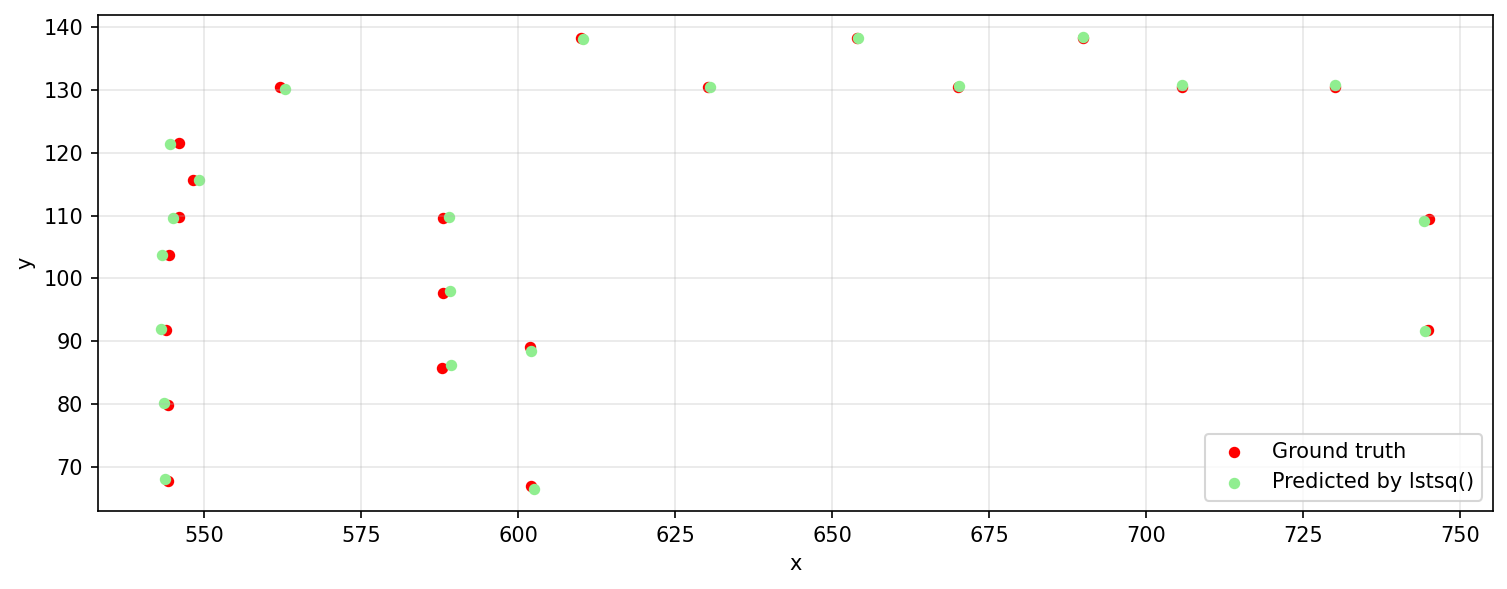

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# R_LONG = 6378137
# R_SHORT = 6356752.3142
# E_EARTH: np.float64 = np.sqrt(1 - (R_SHORT / R_LONG) ** 2)
INS_OFFSET_X = 0.54259766
INS_OFFSET_Y = 3.10864216


# def lla_to_ecef(lon_rad, lat_rad, alt):
#     N = R_LONG / np.sqrt(1 - E_EARTH ** 2 * np.sin(lat_rad))
#     return (
#         (N + alt) * np.cos(lat_rad) * np.cos(lon_rad),
#         (N + alt) * np.cos(lat_rad) * np.sin(lon_rad),
#         (N * (R_LONG / R_SHORT) ** 2 + alt) * np.sin(lat_rad),
#     )


# def ecef_to_enu(lon_rad, lat_rad, ecef_dx, ecef_dy, ecef_dz):
#     e = -np.sin(lon_rad) * ecef_dx + np.cos(lon_rad) * ecef_dy
#     n = -np.cos(lon_rad) * np.sin(lat_rad) * ecef_dx \
#         - np.sin(lon_rad) * np.sin(lat_rad) * ecef_dy \
#         + np.cos(lat_rad) * ecef_dz
#     u = np.cos(lon_rad) * np.cos(lat_rad) * ecef_dx \
#         + np.sin(lon_rad) * np.cos(lat_rad) * ecef_dy \
#         + np.sin(lat_rad) * ecef_dz
#     return e, n, u


def center_to_ins(x, y, heading):
    return (
        x + INS_OFFSET_X * np.cos(heading) - INS_OFFSET_Y * np.sin(heading),
        y + INS_OFFSET_X * np.sin(heading) + INS_OFFSET_Y * np.cos(heading),
    )


def ins_to_center(ins_x, ins_y, heading):
    x = ins_x - INS_OFFSET_X * np.cos(heading) \
        + INS_OFFSET_Y * np.sin(heading)
    y = ins_y - INS_OFFSET_X * np.sin(heading) \
        - INS_OFFSET_Y * np.cos(heading)
    return x, y


n_samples = len(df_data)

lon = df_data["lon"].to_numpy()
lat = df_data["lat"].to_numpy()
# alt = df_data["alt"].to_numpy()
center_x = df_data["center_x"].to_numpy()
center_y = df_data["center_y"].to_numpy()
heading = df_data["heading"].to_numpy()

ins_x, ins_y = center_to_ins(center_x, center_y, heading)
lon_rad = lon * np.pi / 180
lat_rad = lat * np.pi / 180

# ref_lon_rad = np.mean(lon_rad)
# ref_lat_rad = np.mean(lat_rad)
# ref_alt = np.mean(alt)
# ref_ins_x = np.mean(ins_x)
# ref_ins_y = np.mean(ins_y)
# ref_lon_rad = lon_rad[0]
# ref_lat_rad = lat_rad[0]
# ref_alt = alt[0]
# ref_ins_x = ins_x[0]
# ref_ins_y = ins_y[0]
# ref_center_x = center_x[0]
# ref_center_y = center_y[0]
# ref_lon_rad = 120.234438 * np.pi / 180
# ref_lat_rad = 36.009284 * np.pi / 180
# ref_alt = np.mean(alt)
# ref_ins_x = 0
# ref_ins_y = 0

# print("LLA Origin =")
# print(np.array([
#     ref_lon_rad * 180 / np.pi,
#     ref_lat_rad * 180 / np.pi,
#     ref_alt,
# ]))
# print("INS Origin =")
# print(np.array([ref_ins_x, ref_ins_y]))

# ecef_x0, ecef_y0, ecef_z0 = \
#     lla_to_ecef(ref_lon_rad, ref_lat_rad, ref_alt)
# print("ECEF Origin =")
# print(np.array([ecef_x0, ecef_y0]))

# ecef_x, ecef_y, ecef_z = \
#     lla_to_ecef(lon_rad, lat_rad, alt)
# ecef_dx = ecef_x - ecef_x0
# ecef_dy = ecef_y - ecef_y0
# ecef_dz = ecef_z - ecef_z0

# enu_x, enu_y, enu_z = \
#     ecef_to_enu(lon_rad, lat_rad, ecef_dx, ecef_dy, ecef_dz)

A = np.hstack([
    lat.reshape((n_samples, 1)),
    lon.reshape((n_samples, 1)),
    # (lat * lon).reshape((n_samples, 1)),
    # lat_rad.reshape((n_samples, 1)),
    # lon_rad.reshape((n_samples, 1)),
    # enu_x.reshape((n_samples, 1)),
    # enu_y.reshape((n_samples, 1)),
    # enu_z.reshape((n_samples, 1)),
    # (enu_x ** 2).reshape((n_samples, 1)),
    # (enu_y ** 2).reshape((n_samples, 1)),
    # (enu_z ** 2).reshape((n_samples, 1)),
    # (enu_x * enu_y).reshape((n_samples, 1)),
    # (enu_y * enu_z).reshape((n_samples, 1)),
    # (enu_z * enu_x).reshape((n_samples, 1)),
    # (enu_x * enu_y * enu_z).reshape((n_samples, 1)),
    # np.cos(heading).reshape((n_samples, 1)),
    # np.sin(heading).reshape((n_samples, 1)),
    np.ones((n_samples, 1)),
])
b = np.vstack([
    ins_x,
    ins_y,
    # center_x,
    # center_y,
]).T

(
    solution,
    residuals,
    rank,
    singular_values,
) = np.linalg.lstsq(A, b)
print("Solution =")
print(solution)
print("Residuals =")
print(residuals)
# print("rank =")
# print(rank)
# print("singular_values =")
# print(singular_values)
# print("INS Offset =")
# print(
#     np.array([
#         (np.abs(solution[2, 0]) + np.abs(solution[3, 1])) / 2,
#         (np.abs(solution[3, 0]) + np.abs(solution[2, 1])) / 2,
#     ])
# )

# ins_pred = A @ solution + np.array([[ref_ins_x, ref_ins_y]] * n_samples)
ins_pred = A @ solution
ins_x_pred = ins_pred[:, 0].ravel()
ins_y_pred = ins_pred[:, 1].ravel()
center_x_pred, center_y_pred = ins_to_center(ins_x_pred, ins_y_pred, heading)
# center_pred = A @ solution
# center_x_pred = center_pred[:, 0].ravel()
# center_y_pred = center_pred[:, 1].ravel()

df_comp = df_data.copy()
df_comp["center_x_pred"] = center_x_pred
df_comp["center_y_pred"] = center_y_pred
df_comp["dis"] = np.sqrt(
    (center_x_pred - center_x) ** 2 + (center_y_pred - center_y) ** 2
)

fig = plt.figure(figsize=(12, 12), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()
df_comp.plot.scatter(x="center_x", y="center_y", c="red", marker="o",
                     s=20, ax=ax, label="Ground truth")
df_comp.plot.scatter(x="center_x_pred", y="center_y_pred", c="lightgreen", marker="o",
                     s=20, ax=ax, label="Predicted by lstsq()")
# ax.plot(ref_center_x, ref_center_y, "k+", label="ENU origin")

ax.set(
    xlabel="x",
    ylabel="y",
    aspect="equal",
)
ax.legend()
ax.grid(alpha=0.3)

df_comp.sort_values(by="dis", ascending=False)[[
    "center_x",
    "center_x_pred",
    "center_y",
    "center_y_pred",
    "heading",
    "dis"
]]

## C++ Code

In [4]:
print("// GPS 定位点的车身坐标")
print(f"const double INS_OFFSET_X = {INS_OFFSET_X};")
print(f"const double INS_OFFSET_Y = {INS_OFFSET_Y};")
print()
# print("// 参考点坐标")
# print(f"const static double ORIGIN_LAT = {ref_lat_rad * 180 / np.pi}; // 参考点纬度")
# print(f"const static double ORIGIN_LON = {ref_lon_rad * 180 / np.pi}; // 参考点经度")
# # print(f"const static double ORIGIN_ALT = {ref_alt}; // 参考点海拔")
# print(f"const static double ORIGIN_INS_X = {ref_ins_x}; // 参考点 INS X 坐标")
# print(f"const static double ORIGIN_INS_Y = {ref_ins_y}; // 参考点 INS Y 坐标")
# print()
print("// 转换为车辆中心坐标")
print(
    "center_x = "
    # "ORIGIN_INS_X\n    + "
    "INS_OFFSET_X * -cos_heading"
    "\n    + INS_OFFSET_Y * sin_heading"
    "\n    + %.12f * latitude"
    "\n    + %.12f * longitude"
    # "\n    + %.12f * lat_integrated"
    # "\n    + %.12f * lon_integrated"
    # "\n    + %.12f * enu_x"
    # "\n    + %.12f * enu_y"
    # "\n    + %.12f * enu_z"
    # "\n    + %.12f * cos_heading"
    # "\n    + %.12f * sin_heading"
    "\n    + %.12f"
    ";"
    % tuple(solution[:, 0].ravel())
)
print(
    "center_y = "
    # "ORIGIN_INS_Y\n    + "
    "INS_OFFSET_X * -sin_heading"
    "\n    + INS_OFFSET_Y * -cos_heading"
    "\n    + %.12f * latitude"
    "\n    + %.12f * longitude"
    # "\n    + %.12f * lat_integrated"
    # "\n    + %.12f * lon_integrated"
    # "\n    + %.12f * enu_x"
    # "\n    + %.12f * enu_y"
    # "\n    + %.12f * enu_z"
    # "\n    + %.12f * cos_heading"
    # "\n    + %.12f * sin_heading"
    "\n    + %.12f"
    ";"
    % tuple(solution[:, 1].ravel())
)

// GPS 定位点的车身坐标
const double INS_OFFSET_X = 0.54259766;
const double INS_OFFSET_Y = 3.10864216;

// 转换为车辆中心坐标
center_x = INS_OFFSET_X * -cos_heading
    + INS_OFFSET_Y * sin_heading
    + 66275.607713408215 * latitude
    + 71809.470234091146 * longitude
    + -11020441.970898680389;
center_y = INS_OFFSET_X * -sin_heading
    + INS_OFFSET_Y * -cos_heading
    + 86940.240254984470 * latitude
    + -54311.127441424738 * longitude
    + 3399782.997455371544;


## Test

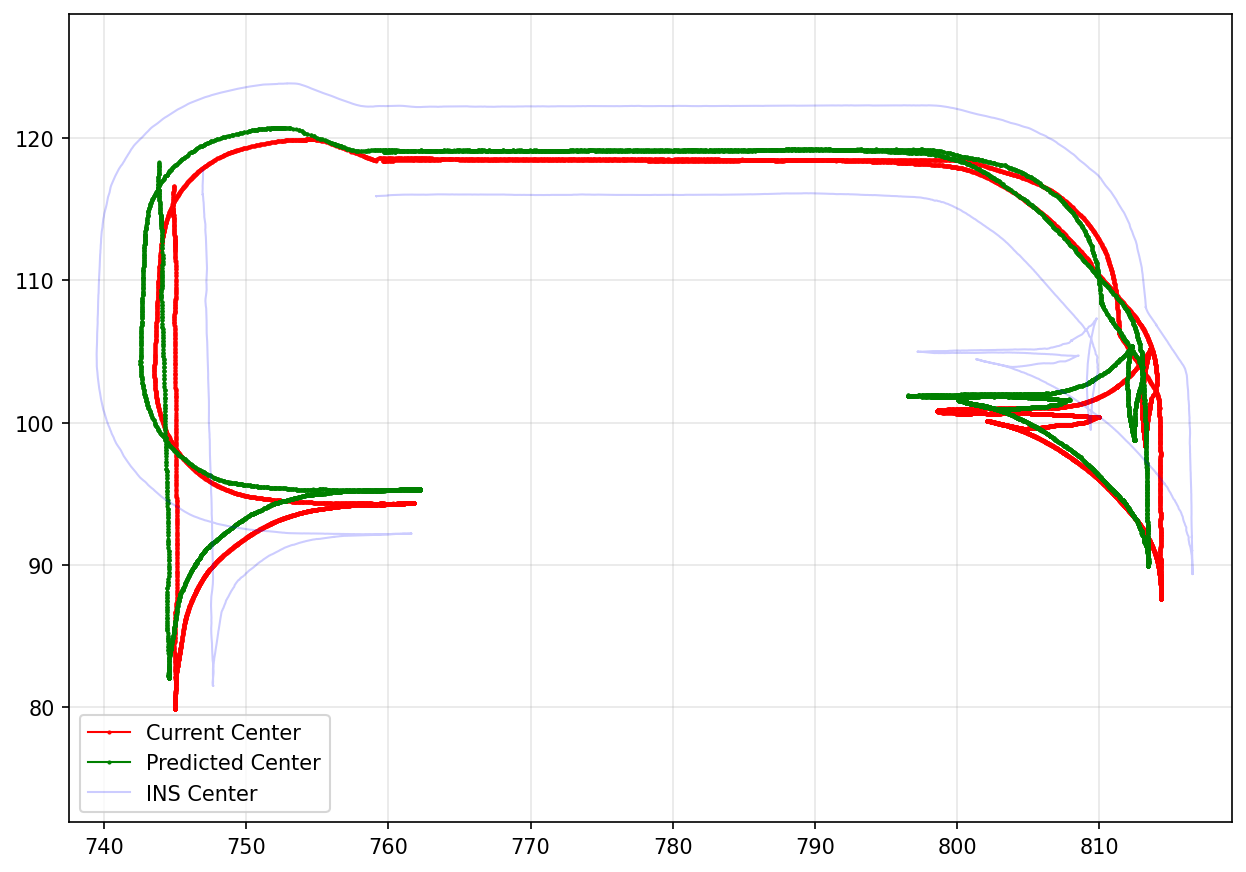

In [6]:
df_log_raw = pd.read_csv(
    "../local/log/1125/asc/手动行驶2/tracking_control_node.csv"
)
df_log = df_log_raw.query("valid == 1 and gps_lon_integrated > 0")
n_log = len(df_log)
# log_lat = df_log["gps_lat_integrated"].to_numpy()
# log_lon = df_log["gps_lon_integrated"].to_numpy()
log_lat = df_log["gps_latitude"].to_numpy()
log_lon = df_log["gps_longitude"].to_numpy()
# log_lat_rad = np.deg2rad(log_lat)
# log_lon_rad = np.deg2rad(log_lon)
log_heading = df_log["heading"].to_numpy()
# log_ecef = lla_to_ecef(
#     log_lon_rad,
#     log_lat_rad,
#     ref_alt,
# )
# log_enu = ecef_to_enu(
#     log_lon_rad,
#     log_lat_rad,
#     log_ecef[0] - ecef_x0,
#     log_ecef[1] - ecef_y0,
#     log_ecef[2] - ecef_z0,
# )
column_shape = (n_log, 1)
A_log = np.hstack([
    log_lat.reshape(column_shape),
    log_lon.reshape(column_shape),
    # (log_lat * log_lon).reshape(column_shape),
    # log_enu[0].reshape(column_shape),
    # log_enu[1].reshape(column_shape),
    # np.cos(log_heading).reshape(column_shape),
    # np.sin(log_heading).reshape(column_shape),
    np.ones(column_shape),
])
pred_log = A_log @ solution
ins_x = pred_log[:, 0].ravel() # + ref_ins_x
ins_y = pred_log[:, 1].ravel() # + ref_ins_y
pred_log_x, pred_log_y = ins_to_center(ins_x, ins_y, log_heading)

fig = plt.figure(figsize=(10, 10), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

x_center = df_log["x_center"].to_numpy()
y_center = df_log["y_center"].to_numpy()
ax.plot(x_center, y_center, "r.-", lw=1, ms=2, label="Current Center")
ax.plot(pred_log_x, pred_log_y, "g.-", lw=1, ms=2, label="Predicted Center")
ax.plot(ins_x, ins_y, "b-", lw=1, alpha=0.2, label="INS Center")
# ax.plot(log_enu[0], log_enu[1], "y.-", lw=1. ms=2, label="ENU")

ax.set(
    aspect="equal",
    xlim=(
        min(pred_log_x.min(), x_center.min()) - 5,
        max(pred_log_x.max(), x_center.max()) + 5,
    ),
    ylim=(
        min(pred_log_y.min(), y_center.min()) - 8,
        max(pred_log_y.max(), y_center.max()) + 8,
    ),
)
ax.legend()
ax.grid(alpha=0.3)

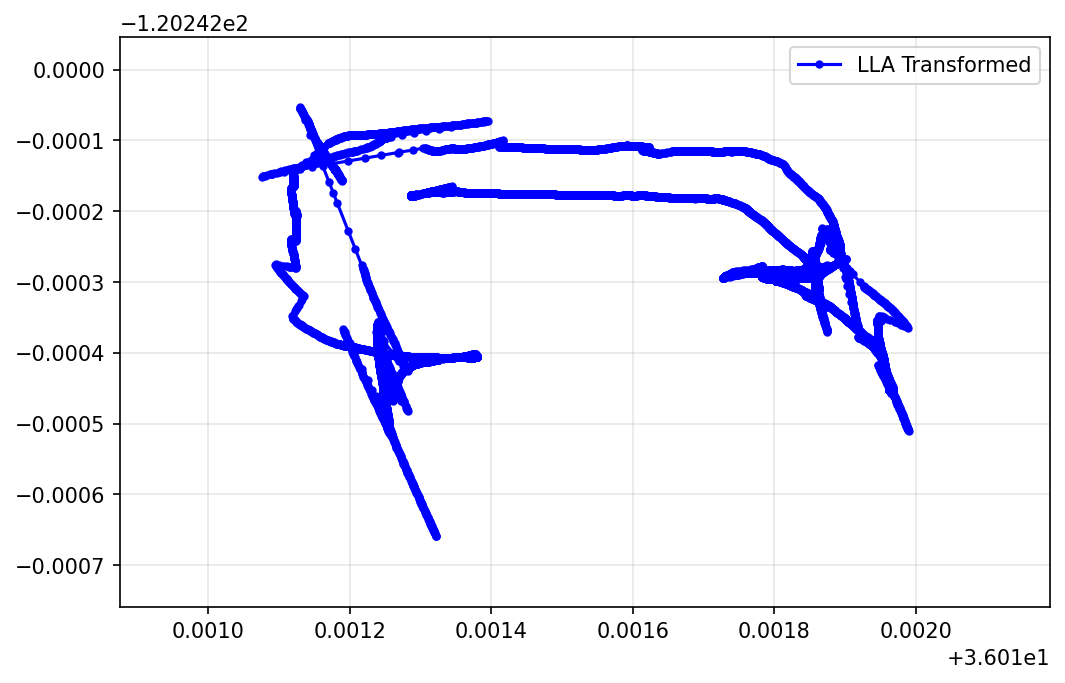

In [ ]:
ll = df_log[["gps_lat_integrated", "gps_lon_integrated"]].to_numpy()
rot = -57 * np.pi / 180
R = np.array([
    [np.cos(rot), -np.sin(rot)],
    [np.sin(rot), np.cos(rot)],
])
x, y = R @ (ll - ll[0, :].reshape(1, 2)).T \
    + ll[0, :].reshape(2, 1)

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

y = -y

# ax.plot(df_log["x_center"], df_log["y_center"], "r.-", label="Current Center")
ax.plot(x, y, "b.-", label="LLA Transformed")

ax.set(
    aspect="equal",
    xlim=(x.min() - 0.0002, x.max() + 0.0002),
    ylim=(y.min() - 0.0001, y.max() + 0.0001),
)
ax.legend()
ax.grid(alpha=0.3)

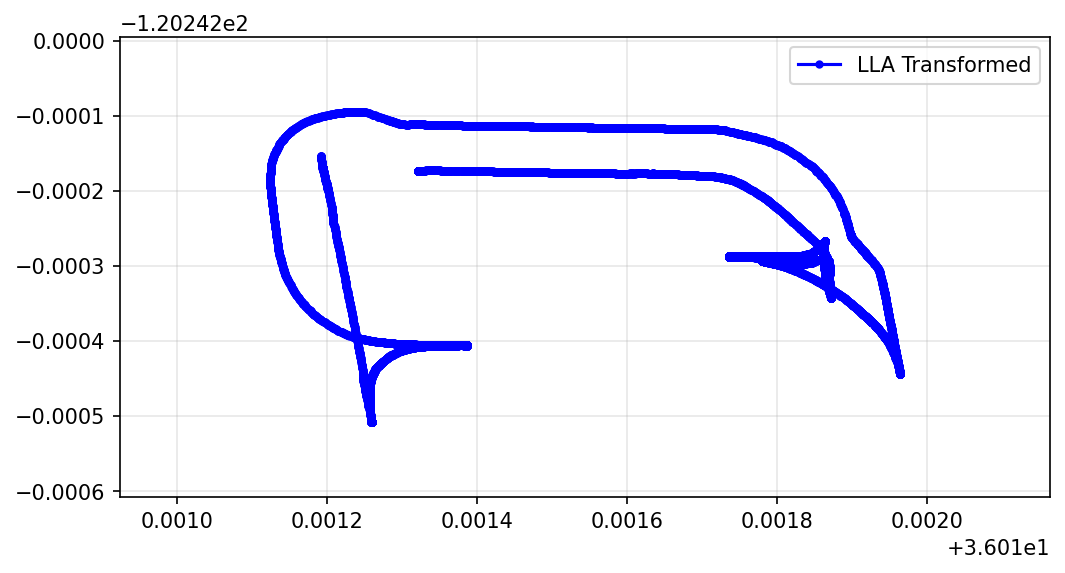

In [ ]:
ll = df_log[["gps_latitude", "gps_longitude"]].to_numpy()
rot = -57 * np.pi / 180
R = np.array([
    [np.cos(rot), -np.sin(rot)],
    [np.sin(rot), np.cos(rot)],
])
x, y = R @ (ll - ll[0, :].reshape(1, 2)).T \
    + ll[0, :].reshape(2, 1)

fig = plt.figure(figsize=(8, 6), dpi=150)
fig.set_facecolor("#fff")
ax = fig.add_subplot()

y = -y

# ax.plot(df_log["x_center"], df_log["y_center"], "r.-", label="Current Center")
ax.plot(x, y, "b.-", label="LLA Transformed")

ax.set(
    aspect="equal",
    xlim=(x.min() - 0.0002, x.max() + 0.0002),
    ylim=(y.min() - 0.0001, y.max() + 0.0001),
)
ax.legend()
ax.grid(alpha=0.3)